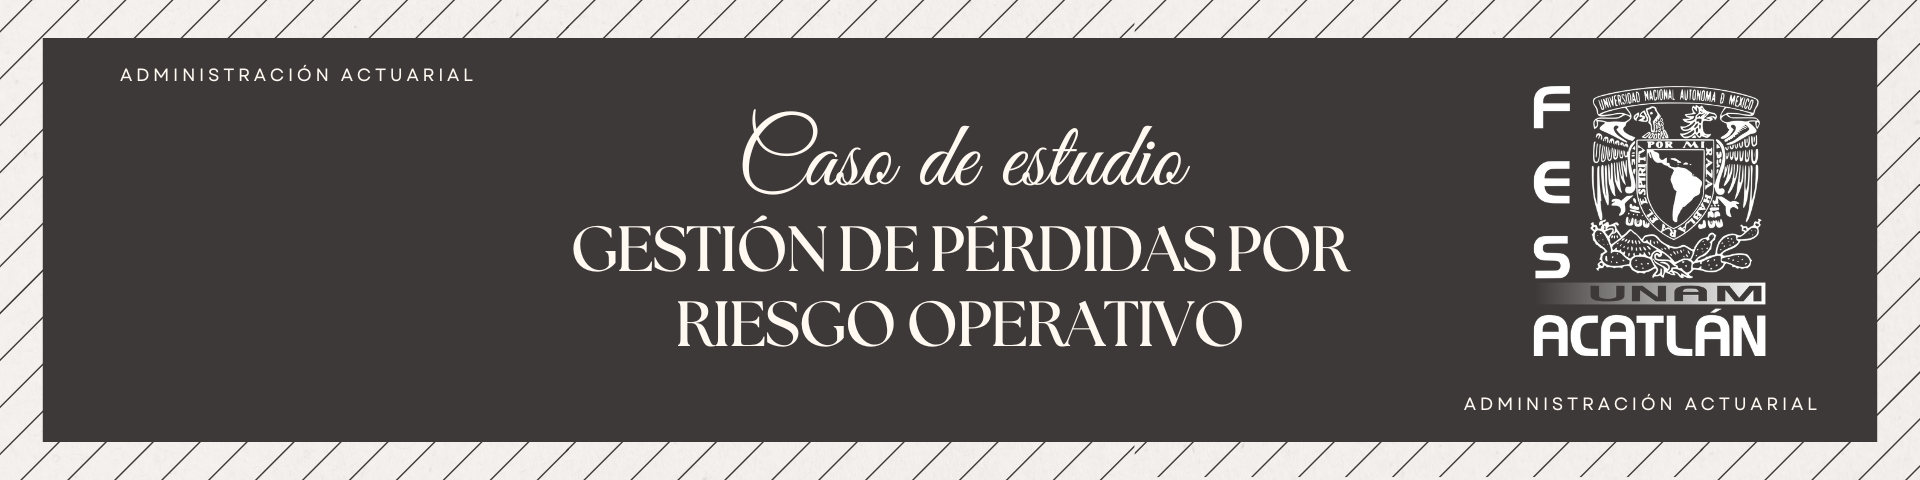

# Integrantes del Equipo



*   DIAZ SANCHEZ DAVID
*   GALÁN OLIVARES JUAN MIGUEL
*   MORALES RAMIREZ ANGEL FRANCISCO
*   SOTO LUNA DENILSON
*   ZUÑIGA GALVAN DIEGO ANTONIO






In [ ]:
# Definimos todas las librerías que usaremos para programar el modelo
# Nos ayudarán a manejar los datos, visualizar graficamente los los datos
# y estimar las funciones empíricas.

import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from scipy.stats import binom, nbinom
from scipy.interpolate import interp1d

In [ ]:
# Subimos los datos a github, los descargamos y guardamos en un dataframe

url = "https://github.com/DavidDiaz24/Administracion_Act/raw/2a73f10fac73a302a7ef0dff1e3f59ee24d16d92/Base_Diferencia_de_Inventarios.xlsx"
datos = pd.read_excel(url, engine='openpyxl')
datos.head()

,Fecha,Diferencia de Inventarios
0,2019-01-11,166.29
1,2019-01-22,120.48
2,2019-02-02,9255.43
3,2019-02-04,1938.44
4,2019-02-10,67.56


# Para la variable aleatoria N

In [ ]:
# Vamos agrupar los datos para poder encontrar las observaciones que tuvo la
# Variable aleatoria N_i que será en días, dado por los datos.
# Agrupamos por fecha y contamos.

por_fecha = datos.groupby("Fecha").count()

# También extraemos la cantidad de observaciones que tuvo la variable n en los datos.
cantidad_n_obs = por_fecha.describe().loc["count"][0]

<ipython-input-3-6a5101a14db2>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cantidad_n_obs = por_fecha.describe().loc["count"][0]


###En la siguiente gráfica no estamos viendo las observaciones de cuando N=0

array([[<Axes: title={'center': 'Diferencia de Inventarios'}>]],
      dtype=object)

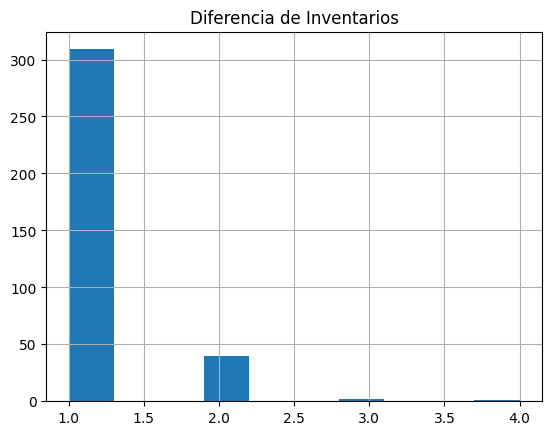

In [ ]:
# No observamos cuando N_i = 0, por lo que debemos considerar esa posibilidad y además la ocurrencia del evento
# Si no lo consideraramos, nuestro modelo nunca podría valer cero en el caso de reclamaciones diarias,
# lo que llevaría a sobreestimar el riesgo.

por_fecha.hist()

In [ ]:
# Calculamos la cantidad de ceros, obtenemos la cantidad de días que hubo en los años donde hubo observaciones, en este caso 5 años.
# Le restamos la cantidad de observaciones para obtener el número preciso.

cantidad_n_cero =int(365*5 + 1 - cantidad_n_obs)
cantidad_n_cero

1474

In [ ]:
# Creamos un dataframe de zeros con la cantidad de observaciones N_i = 0

xeros = pd.DataFrame(np.zeros(cantidad_n_cero),[n for n in range(0, cantidad_n_cero)],["Diferencia de Inventarios"])

In [ ]:
estadisticas_N = pd.concat([por_fecha,xeros]).describe()
mean_N = estadisticas_N.loc["mean"]
variance_N = estadisticas_N.loc["std"]**2

In [ ]:
# Concatenamos verticalmente para tener un dataframe con todas las observaciones de N_i en los 5 años.

N_obs = pd.concat([por_fecha,xeros])

# Estimamos su Función de Distribución Empírica
ecdf_N = ECDF(N_obs["Diferencia de Inventarios"])

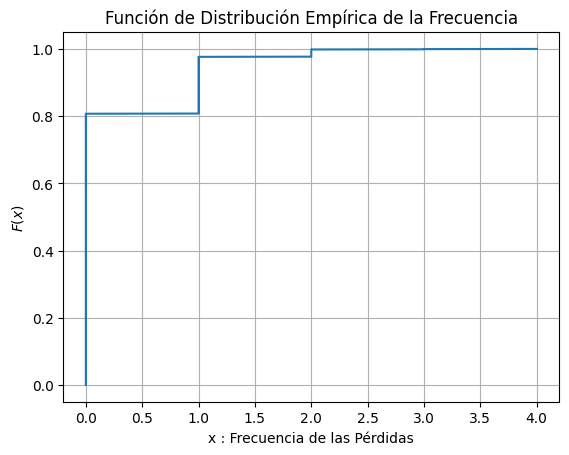

In [ ]:
# Graficamos la Distribución

plt.plot(ecdf_N.x, ecdf_N.y, marker=',', linestyle='-')
plt.xlabel(r'x : Frecuencia de las Pérdidas')
plt.ylabel(r'$F(x)$')
plt.title('Función de Distribución Empírica de la Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
# Simular observaciones de N
# Aquí simularemos observaciones de la N_i diaria

def N_sim(n):
  n_sim = np.array([])
  for i in range(0,n):
    u = np.random.rand(1)
    k = 0
    while u >= ecdf_N(k):
      k += 1
    n_sim = np.append(n_sim, k)
  return n_sim

(array([[<Axes: title={'center': '0'}>]], dtype=object),
 array([[<Axes: title={'center': 'Diferencia de Inventarios'}>]],
       dtype=object))

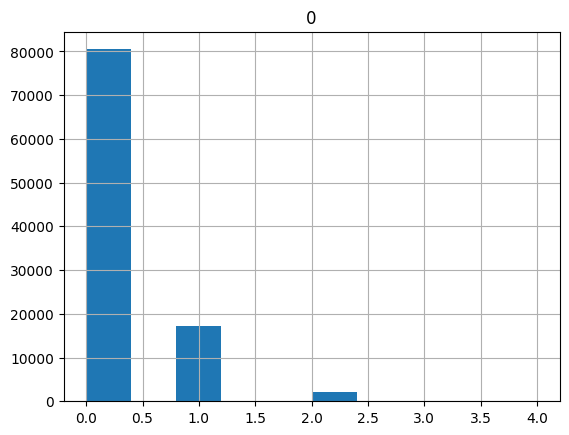

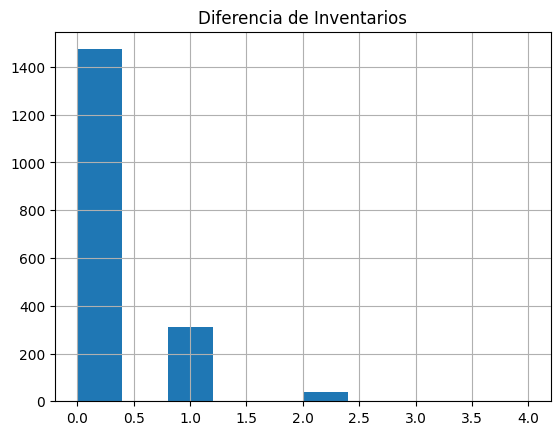

In [ ]:
# Comparamos los histogramas de la N_i simulada y las observaciones de N_i de los datos.
# Observamos que se comporta igual que los datos en proporción.

pd.DataFrame(N_sim(100000)).hist(),N_obs.hist()

Para proceder necesitamos pasar todo de días a años, simplemente la nueva variable aleatoria sera N = ∑ⁿ Nᵢ, donde n = 366 días del año 2024 y Nᵢ es la variable de la frecuencia diaria.

In [ ]:
# Simular N
def N_anual(k):
  n_anual = np.array([])
  for i in range(0,k):
    nobs = N_sim(366)   # Ya que el año 2024 es año Biciesto
    n_anual = np.append(n_anual, nobs.sum())
  return n_anual

In [ ]:
# Simulamos 10_000 veces la variable aleatoria anual

N_simuladas = N_anual(10_000)

In [ ]:
# Estimamos sus estadisticas para ver relaciones y entender su comportamiento.

EN_anual = N_simuladas.mean()
VN_anual = N_simuladas.var()
EN_anual, VN_anual

(79.8769, 82.93674638999998)

array([[<Axes: title={'center': '0'}>]], dtype=object)

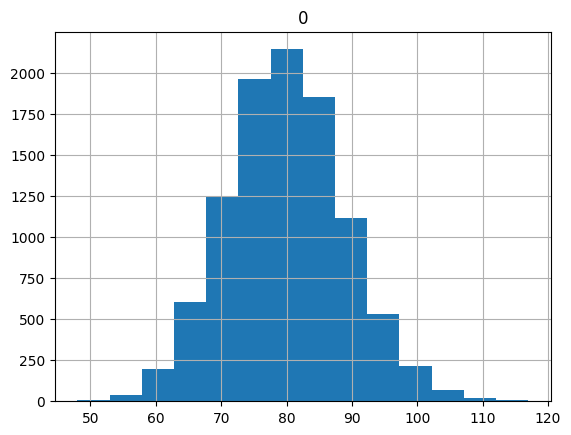

In [ ]:
# Graficamos el histograma de nuestra simulación de N

pd.DataFrame(N_simuladas).hist(bins = 14)

Claramente la variable aleatoria N_anual, puede ser ajustada con algún modelo conocido, para que sea mucho más rápida la simulación de las pérdidas.

Además como E(N) < Var(N) podríamos pensar en Binomial Negativa, estimaremos sus parámetros por el método de momentos para mayor exactitud.

In [ ]:
# Estimadores por el Método de Momentos
# Estimamos por el método de momentos ya que los MLE son un poco más dificil de estimar.

r_est = round(((EN_anual)**2) / (VN_anual - EN_anual))
p_est = EN_anual/VN_anual
r_est, p_est

(2085, 0.963106264434206)

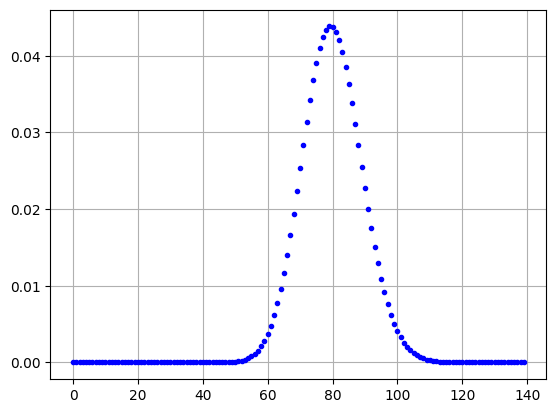

In [ ]:
# Graficamos la función de probabilidad de la N ~ Binomial Negativa(r_est, p_est)

x = np.arange(0,140)
y = nbinom.pmf(x, r_est, p_est)

plt.plot(x, y, label = "pmf",color="blue" , marker='.', linestyle='')
plt.grid(True)
plt.show()

Encontramos un modelo para ajustar N anual con gran precisión.

---



# Para las variables aleatorias Xᵢ

<Axes: >

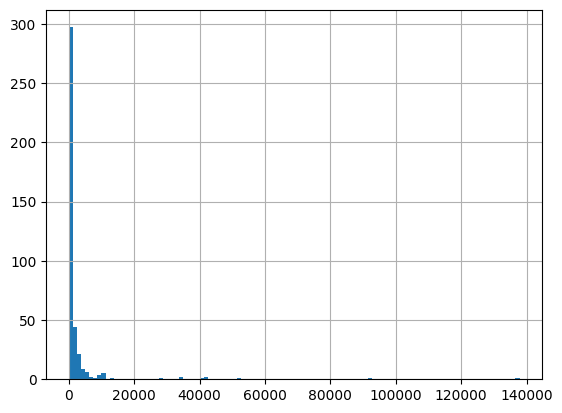

In [ ]:
# Graficamos el Histograma de las Reclamaciones

datos["Diferencia de Inventarios"].hist(bins=110)

# Observamos que tiene una forma un tanto similar a una Gamma,
# Pero usaremos técnicas no paramétricas para estimar su distribución y no perder información.

In [ ]:
# Estimamos la Función de Distribución Empírica de X_i

ecdf_X = ECDF(datos["Diferencia de Inventarios"])

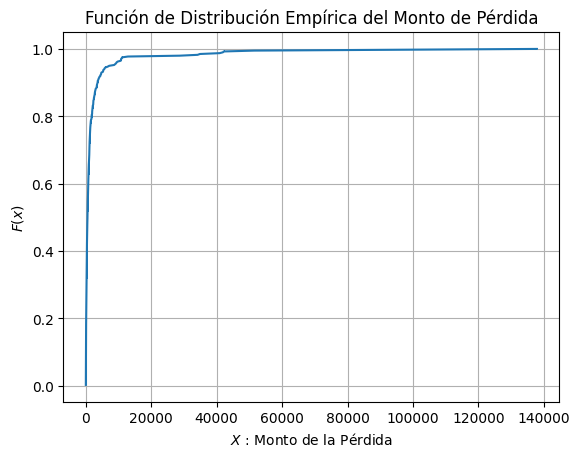

In [ ]:
# Graficamos los valores de la función para observar como es.

plt.plot(ecdf_X.x, ecdf_X.y, marker=',', linestyle='-')
plt.xlabel(r'$X$ : Monto de la Pérdida')
plt.ylabel(r'$F(x)$')
plt.title('Función de Distribución Empírica del Monto de Pérdida')
plt.grid(True)
plt.show()

In [ ]:
# Pseudo inversa de la función de distribución empírica
# Parte para empezar a suavizarla, necesitamos realizar esto para poder simular directamente con ella
# sin necesidad de pasar a lo paramétrico

xobs = np.sort(np.array(datos["Diferencia de Inventarios"]))

ECDF_psein = np.empty(0)

for x in range(0,len(xobs)+1):
  if x == 0:
    ECDF_psein = np.append(ECDF_psein, xobs[0])
  elif x == len(xobs):
    ECDF_psein = np.append(ECDF_psein, xobs[-1])
  else:
    ECDF_psein = np.append(ECDF_psein, (xobs[x]+xobs[x-1])/2)

In [ ]:
# Polinomios de Bernstein
# Una técnica muy conveniente y fácil de programar para suavizar la distribución empírica
# Nos dará una aproximación de la verdadera función de distribución inversa de X_i


def B_n(t):
  n = len(xobs)
  bn_t = 0
  for k in range(0, n+1):
    bn_t += ECDF_psein[k] * binom.pmf(k, n, t)
  return bn_t

In [ ]:
# Creamos los ejes para gráficarla
x = np.linspace(0,1, 1000)
y = B_n(x)

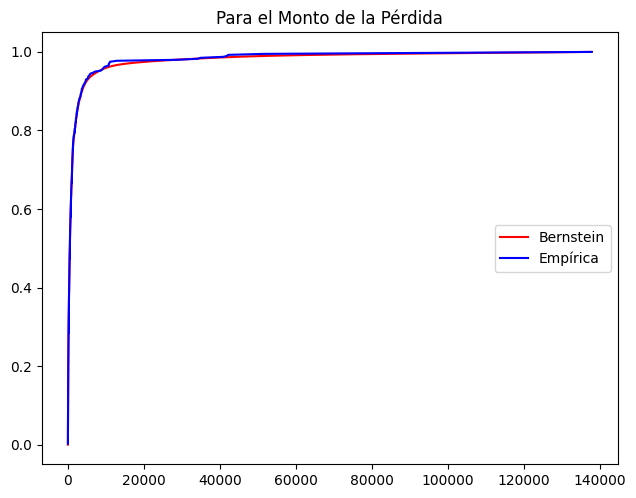

In [ ]:
# La graficamos junto con la empírica y observamos que esta representando muy bien el comportamiento de la distribución
# Tanto que solo se ve ligeramente por debajo de la empírica.

figura = plt.figure()
graficos=figura.add_axes([0.1,0.1,0.9,0.9])
graficos.plot(y,x,color = "red", label='Bernstein')
graficos.plot(ecdf_X.x, ecdf_X.y, label = "Empírica",color="blue" , marker=',', linestyle='-')
plt.title('Para el Monto de la Pérdida')
graficos.legend(loc=5)

 Ahora ya tenemos una manera de simular de una manera muy exacta la variable de las reclamaciones.

---



# Continuamos con la simulación para la variable aleatoria L

In [ ]:
# Función que simula las X_j para una N = n
# Necesitamos esta función para agilizar la función donde simularemos toda la variable aleatoria L


def X_perdida(n):
  xobs = np.array([])
  if n == 0:
    return 0
  for k in range(0,n):
    u = np.random.rand(1)[0]
    xobs = np.append(xobs, B_n(u))
  return xobs.sum()

## Finalmente la función que simula el Riesgo L

In [ ]:
# Creamos la función para simular la variable del riesgo L

def L(k):
  N = np.random.negative_binomial(r_est, p_est, k)
  L = np.array([])
  for i in N:
    L = np.append(L, X_perdida(i))
  return L

In [ ]:
# Simulamos la variable L
# Tiene un inconveniente a pesar de la precisión con la que simulamos,
# la cual es que se tarda demasiado en realizar las simulaciones.

L_simulada = L(850)

In [ ]:
# Definimos el Dataframe de las simulaciones de L

lobs =  pd.DataFrame(L_simulada)

array([[<Axes: title={'center': '0'}>]], dtype=object)

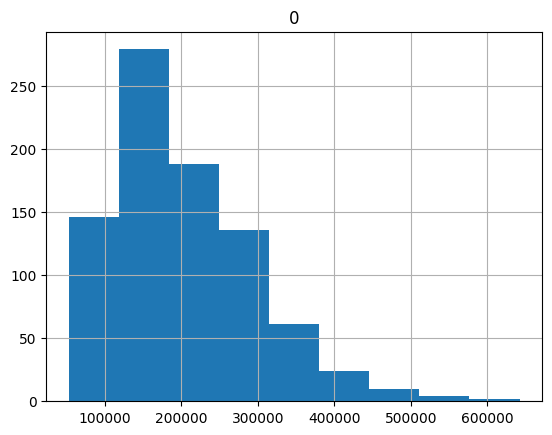

In [ ]:
# Graficamos el histograma de L para observar su forma
# Esto ya es un poco innecesario ya que hemos terminado,

lobs.hist(bins = 9)

# Solución al Problema

In [ ]:
# Calculamos las estadisticas de la variable aleatoria L

media_L = lobs.mean()[0]
v_L = lobs.var()[0]
vaR_0_9 = lobs.quantile(0.9)[0]
print(f"Esperanza(L) = {media_L}, Varianza(L) = {v_L}, Value at risk_0.9 = {vaR_0_9}")

Esperanza(L) = 203211.49679833342, Varianza(L) = 8580830216.169455, Value at risk_0.9 = 327086.75492102525


In [ ]:
# Finalmente encontramos el Capital Requerido para cubrir el riesgo de pérdidas de inventarios

print(f"Value at Risk al 90% = {vaR_0_9} y se espera una pérdida anual de {media_L}")

Value at Risk al 90% = 327086.75492102525 y se espera una pérdida anual de 203211.49679833342
